In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve,r2_score,classification_report
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_curve, auc



In [46]:
df = pd.read_csv("Churn_Modelling.csv")

In [47]:
missing_values=df.isnull().sum()
missing_values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [48]:
to_drop=df.duplicated().sum()
to_drop

np.int64(0)

In [49]:
corr=df.select_dtypes(include='number').corr()

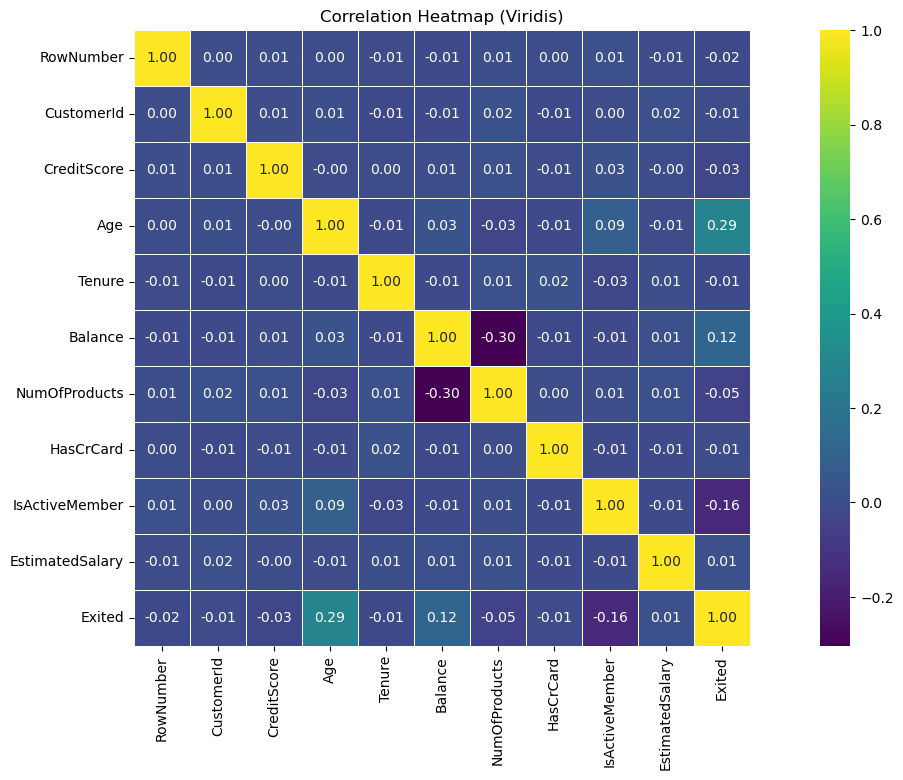

In [50]:
plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", cbar=True,square=True,linewidths=0.5)
plt.title("Correlation Heatmap (Viridis)")
plt.show()


In [51]:
target = "Exited"
drop_cols = ["RowNumber", "CustomerId", "Surname"]
X = df.drop(columns=[target] + [c for c in drop_cols if c in df.columns])
y = df[target]


In [52]:
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [53]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ],
    remainder="passthrough"
)

In [54]:
tree = DecisionTreeClassifier(random_state=42)

In [55]:
pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", tree)
])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [57]:
param_grid = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10, 20]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

Best params: {'model__max_depth': 7, 'model__min_samples_split': 20}
Best CV ROC-AUC: 0.8307114445589467


In [58]:
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]

In [59]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

best_thresh, best_f1 = 0.5, 0
for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"Best threshold: {best_thresh:.2f}, F1: {best_f1:.4f}")

Best threshold: 0.42, F1: 0.6063


In [60]:
y_pred = (y_prob >= best_thresh).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)


print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8305
Precision: 0.5749
Recall: 0.6413
F1: 0.6063
ROC-AUC: 0.8466

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.57      0.64      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000



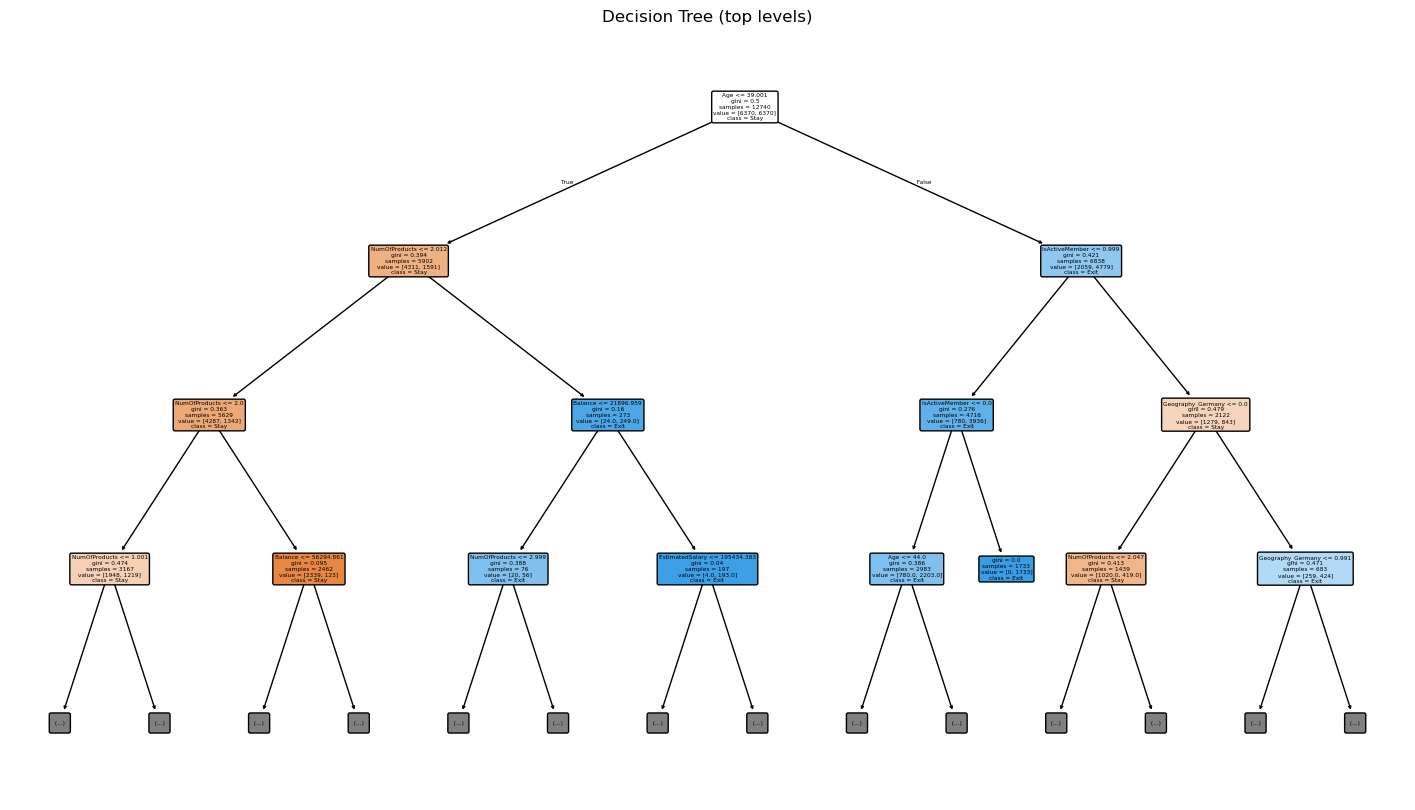

In [65]:
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
final_feature_names = cat_feature_names + [c for c in num_cols]

plt.figure(figsize=(18, 10))
plot_tree(
    best_model.named_steps["model"],
    feature_names=final_feature_names,
    class_names=["Stay", "Exit"],
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("Decision Tree (top levels)")
plt.show()

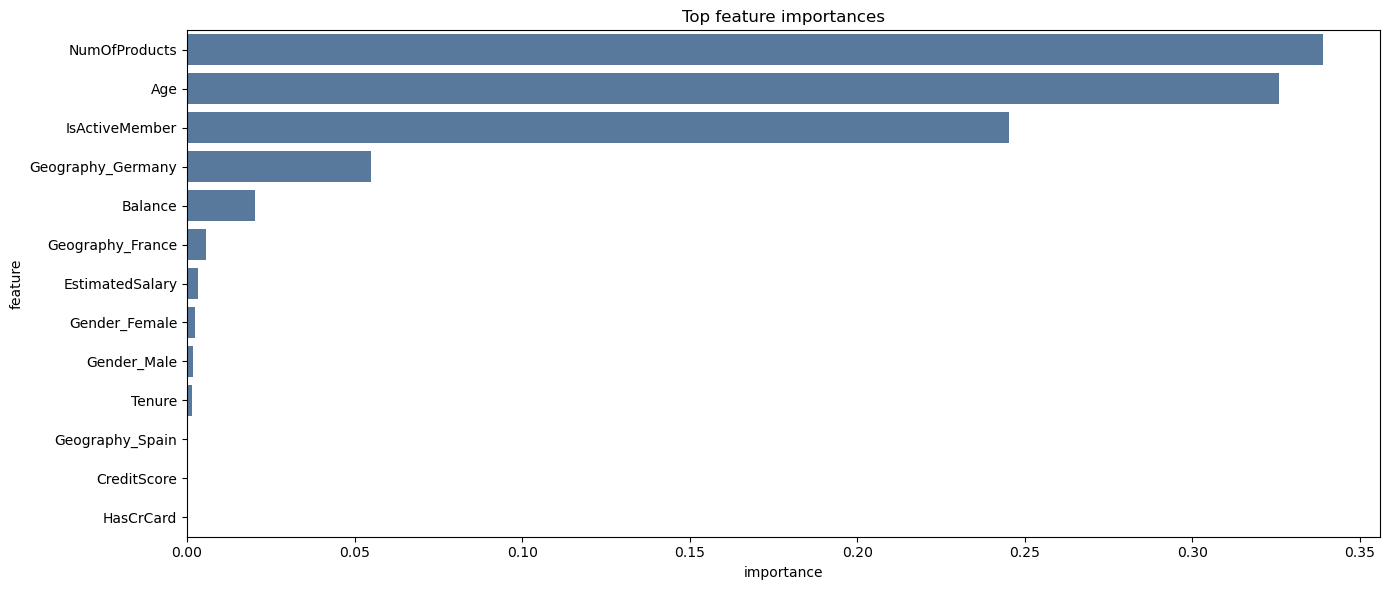

In [62]:
importances = best_model.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": final_feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=fi.head(15), x="importance", y="feature", color="#4C78A8")
plt.title("Top feature importances")
plt.tight_layout()
plt.show()

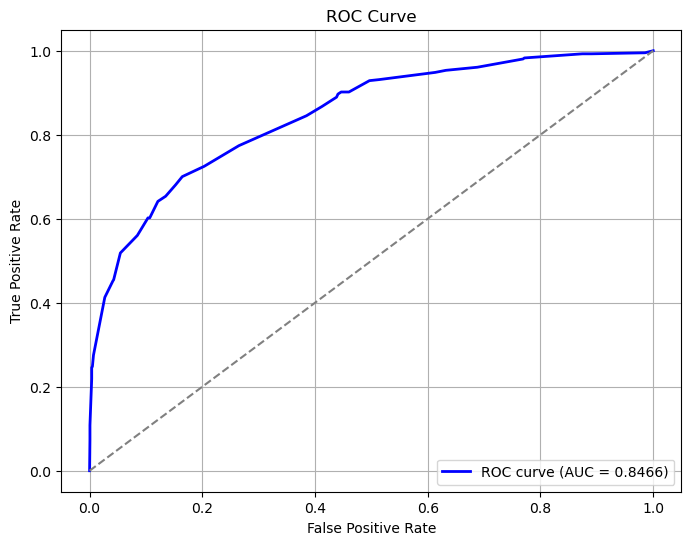

In [63]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--") 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [64]:
import pickle

with open("decision_tree_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Model saved successfully as decision_tree_model.pkl")


✅ Model saved successfully as decision_tree_model.pkl
